In [1]:
import cv2
import os
from joblib import Parallel, delayed
from tqdm import tqdm
import re
import numpy as np
import scipy
import skimage
import ants
import matplotlib.pyplot as plt


def get_ksize(sigma):
    # opencv calculates ksize from sigma as
    # sigma = 0.3*((ksize-1)*0.5 - 1) + 0.8
    # then ksize from sigma is
    # ksize = ((sigma - 0.8)/0.15) + 2.0

    return int(((sigma - 0.8) / 0.15) + 2.0)


def get_gaussian_blur(img, ksize=0, sigma=5):
    # if ksize == 0, then compute ksize from sigma
    if ksize == 0:
        ksize = get_ksize(sigma)

    # Gaussian 2D-kernel can be seperable into 2-orthogonal vectors
    # then compute full kernel by taking outer product or simply mul(V, V.T)
    sep_k = cv2.getGaussianKernel(ksize, sigma)

    # if ksize >= 11, then convolution is computed by applying fourier transform
    return cv2.filter2D(img, -1, np.outer(sep_k, sep_k))


def ssr(img, sigma):
    # Single-scale retinex of an image
    # SSR(x, y) = log(I(x, y)) - log(I(x, y)*F(x, y))
    # F = surrounding function, here Gaussian

    return np.log10(img) - np.log10(get_gaussian_blur(img, ksize=0, sigma=sigma) + 1.0)


def msr(img, sigma_scales=[15, 80, 250]):
    # Multi-scale retinex of an image
    # MSR(x,y) = sum(weight[i]*SSR(x,y, scale[i])), i = {1..n} scales

    msr = np.zeros(img.shape)
    # for each sigma scale compute SSR
    for sigma in sigma_scales:
        msr += ssr(img, sigma)

    # divide MSR by weights of each scale
    # here we use equal weights
    msr = msr / len(sigma_scales)

    # computed MSR could be in range [-k, +l], k and l could be any real value
    # so normalize the MSR image values in range [0, 255]
    msr = cv2.normalize(msr, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)

    return msr


def color_balance(img, low_per, high_per):
    """Contrast stretch img by histogram equilization with black and white cap"""

    tot_pix = img.shape[1] * img.shape[0]
    # no.of pixels to black-out and white-out
    low_count = tot_pix * low_per / 100
    high_count = tot_pix * (100 - high_per) / 100

    # channels of image
    ch_list = []
    if len(img.shape) == 2:
        ch_list = [img]
    else:
        ch_list = cv2.split(img)

    cs_img = []
    # for each channel, apply contrast-stretch
    for i in range(len(ch_list)):
        ch = ch_list[i]
        # cummulative histogram sum of channel
        cum_hist_sum = np.cumsum(cv2.calcHist([ch], [0], None, [256], (0, 256)))

        # find indices for blacking and whiting out pixels
        li, hi = np.searchsorted(cum_hist_sum, (low_count, high_count))
        if li == hi:
            cs_img.append(ch)
            continue
        # lut with min-max normalization for [0-255] bins
        lut = np.array(
            [
                0 if i < li else (255 if i > hi else round((i - li) / (hi - li) * 255))
                for i in np.arange(0, 256)
            ],
            dtype="uint8",
        )
        # constrast-stretch channel
        cs_ch = cv2.LUT(ch, lut)
        cs_img.append(cs_ch)

    if len(cs_img) == 1:
        return np.squeeze(cs_img)
    elif len(cs_img) > 1:
        return cv2.merge(cs_img)
    return None


def msrcr(
    img,
    sigma_scales=[15, 80, 250, 500],
    # sigma_scales=[16, 32, 64],
    alpha=125,
    beta=46,
    G=192,
    b=-30,
    low_per=1,
    high_per=1,
):
    # Multi-scale retinex with Color Restoration
    # MSRCR(x,y) = G * [MSR(x,y)*CRF(x,y) - b], G=gain and b=offset
    # CRF(x,y) = beta*[log(alpha*I(x,y) - log(I'(x,y))]
    # I'(x,y) = sum(Ic(x,y)), c={0...k-1}, k=no.of channels

    img = img.astype(np.float64) + 1.0
    # Multi-scale retinex and don't normalize the output
    msr_img = msr(img, sigma_scales)
    # Color-restoration function
    crf = beta * (np.log10(alpha * img) - np.log10(np.sum(img, axis=2, keepdims=True)))
    # MSRCR
    msrcr_ = G * (msr_img * crf - b)
    # normalize MSRCR
    msrcr_ = cv2.normalize(msrcr_, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)  # type: ignore
    # color balance the final MSRCR to flat the histogram distribution with tails on both sides
    msrcr_ = color_balance(msrcr_, low_per, high_per)

    return msrcr_

In [2]:
class BFIWSlide:
    def __init__(self, slide_path, key=None, is_ref=False):
        self.slide_path = slide_path
        self.key = key
        self.img = cv2.imread(slide_path)
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        self.msr_img = None
        self.msr_img_gray = None
        self.mask = None
        self.is_ref = is_ref
        self.apply_msrcr()
        self.get_mask()
        self.apply_mask(self.mask)

    def apply_msrcr(self):
        self.msr_img = msrcr(self.img)
        self.msr_img_gray = cv2.cvtColor(self.msr_img, cv2.COLOR_RGB2GRAY)

    def apply_mask(self, mask):
        self.temp_img = (np.ones_like(self.img) * 255).astype(np.uint8)
        self.temp_img[mask == 1] = self.img[mask == 1]
        self.img = self.temp_img
        self.temp_img = (np.ones_like(self.img) * 255).astype(np.uint8)
        self.temp_img[mask == 1] = self.msr_img[mask == 1]
        self.msr_img = self.temp_img

    def get_mask(self):
        if self.msr_img_gray is None:
            self.apply_msrcr()
        sample_ants = ants.from_numpy(self.msr_img_gray)
        self.mask = sample_ants.get_mask(cleanup=4).numpy().astype(np.uint8) # type: ignore
        # return self.mask
    
    def apply_crop(self, crop):
        self.img = self.img[crop[0]:crop[1], crop[2]:crop[3]]
        self.msr_img = self.msr_img[crop[0]:crop[1], crop[2]:crop[3]]
        self.mask = self.mask[crop[0]:crop[1], crop[2]:crop[3]]
    
    def get_block_contours(self):
        contours, _ = cv2.findContours(self.mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        self.block_contour=contours[0]
        self.block_bbox =  cv2.boundingRect(self.block_contour)
        self.block_crop = (self.block_bbox[1], self.block_bbox[1]+self.block_bbox[3], self.block_bbox[0], self.block_bbox[0]+self.block_bbox[2])

    def apply_block_crop(self):
        self.apply_crop(self.block_crop)

def make_slide(slide_path, key=None, is_ref=False):
    slide = BFIWSlide(slide_path, key, is_ref)
    return {key: slide}



In [4]:
class BFIWReg:
    def __init__(self, src_dir, dest_dir, ref_idx, step=10, continous_until=200, continous_step=2, max_idx=2600) -> None:
        self.src_dir = src_dir
        self.dest_dir = dest_dir
        imgs = os.listdir(self.src_dir)
        regex = re.compile(r".*-SE_(\d+)_original.jpg")
        imgs = sorted(imgs, key=lambda x: int(regex.match(x).group(1)))
        imgs_ordered = {}
        for img in imgs:
            section_num = int(regex.match(img).group(1))
            section_id = str(section_num)
            section_id_digits = len(section_id)
            if section_id_digits < 4:
                section_id = "0" * (4 - section_id_digits) + str(section_num)
            imgs_ordered[section_id] = os.path.join(self.src_dir, img)
        self.imgs = imgs_ordered
        if ref_idx not in self.imgs:
            raise ValueError("Reference index not found in the image list")
        # self.ref_slide = BFIWSlide(self.imgs[ref_idx], key=ref_idx, is_ref=True)
        self.img_items = list(self.imgs.items())
        self.img_items_continuous = [(k[0], k[1]) for k in self.img_items if int(k[0])<=continous_until]
        self.img_items_continuous = self.img_items_continuous[::continous_step]
        self.img_items_remaining = [(k[0], k[1]) for k in self.img_items if (int(k[0])>continous_until) and (int(k[0])<=max_idx)]
        self.img_items_remaining = self.img_items_remaining[::step]
        self.img_items = self.img_items_continuous + self.img_items_remaining
        if ref_idx not in dict(self.img_items):
            self.img_items.append((ref_idx, self.imgs[ref_idx]))
        self.slides_ = Parallel(n_jobs=32)(
            delayed(make_slide)(img, key) for key, img in tqdm(self.img_items)
        )
        self.slides = {}
        for slide in self.slides_:
            self.slides.update(slide)
        self.ref_slide = self.slides[ref_idx]
        self.ref_slide.is_ref = True
        print("Applying Reference Slide Mask to all slides")
        for key, slide in tqdm(self.slides.items()):
            if key == ref_idx:
                continue
            slide.apply_mask(self.ref_slide.mask)
        self.ref_slide.get_block_contours()
        self.ref_crop = self.ref_slide.block_crop
        print("Applying Reference Slide Crop to all slides")
        for key, slide in tqdm(self.slides.items()):
            slide.apply_crop(self.ref_crop)
        print("Applying Own Slide Block Crop to all slides")
        for key, slide in tqdm(self.slides.items()):
            slide.get_block_contours()
            slide.apply_block_crop()

    def save_output(self):
        print("Saving `img` and `msr_img` of all slides")
        if not os.path.exists(self.dest_dir):
            os.makedirs(self.dest_dir, exist_ok=True)
        if not os.path.exists(os.path.join(self.dest_dir, "msrcr")):
            os.makedirs(os.path.join(self.dest_dir, "msrcr"), exist_ok=True)
        if not os.path.exists(os.path.join(self.dest_dir, "original")):
            os.makedirs(os.path.join(self.dest_dir, "original"), exist_ok=True)
        for key, slide in tqdm(self.slides.items()):
            cv2.imwrite(
                os.path.join(self.dest_dir, f"original/{key}.jpg"),
                cv2.cvtColor(slide.img, cv2.COLOR_RGB2BGR),
            )
            cv2.imwrite(
                os.path.join(self.dest_dir, f"msrcr/{key}_msrcr.jpg"),
                cv2.cvtColor(slide.msr_img, cv2.COLOR_RGB2BGR),
            )


# reg = BFIWReg('/storage/valis_reg/test_block', '/storage/valis_reg/test_block_out', '1606')
# reg.save_output()

In [5]:
reg = BFIWReg('/storage/valis_reg/BFIW_original/', '/storage/valis_reg/train_block_out', '1606')
# reg.save_output()

  0%|          | 0/328 [00:00<?, ?it/s]

100%|██████████| 328/328 [02:04<00:00,  2.64it/s]


Applying Reference Slide Mask to all slides


100%|██████████| 328/328 [02:01<00:00,  2.69it/s]


Applying Reference Slide Crop to all slides


100%|██████████| 328/328 [00:00<00:00, 115008.50it/s]


Applying Own Slide Block Crop to all slides


100%|██████████| 328/328 [00:02<00:00, 148.80it/s]


In [ ]:
list(reg.slides.keys())

In [6]:
reg.save_output()

Saving `img` and `msr_img` of all slides


100%|██████████| 328/328 [00:10<00:00, 30.15it/s]


In [7]:
def transform_img(image):
    image = cv2.GaussianBlur(image, (9, 9), 0.8)
    green_thresh = skimage.filters.threshold_otsu(image[:,:,1])
    img_g = image[:,:,1] <= green_thresh
    img_g = scipy.ndimage.binary_fill_holes(img_g)
    img_g = scipy.ndimage.binary_closing(img_g, iterations=20)
    # Dilation
    kernel = np.ones((3,3),np.uint8)
    img_g = cv2.dilate(img_g.astype(np.uint8), kernel, iterations = 15)

    contours, _ = cv2.findContours(img_g.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    contour = contours[0]
    contour_mask = np.zeros_like(img_g)
    contour_mask = cv2.fillPoly(contour_mask.astype(np.uint8), [contour], 1)
    foreground = cv2.bitwise_and(image, image, mask=contour_mask)
    background = cv2.bitwise_and(image, image, mask=1-contour_mask)
    result = {
        "fg" : foreground,
        "bg" : background,
        "mask" : contour_mask,
        "img_g": img_g
    }
    return result

In [8]:
from time import sleep

train_images = []
label_masks  = []
slide_masks = []
keys = []
count = 0
reg.slides = dict(sorted(reg.slides.items()))
all_reg_slides = list(reg.slides.items())
for k, slide in tqdm(all_reg_slides):
    # if count > 10:
    #     break
    # if k== '1606' or k =='1588':
    #     continue
    tissue_trans = transform_img(slide.msr_img)
    train_images.append(slide.msr_img)
    label_masks.append(tissue_trans['mask'])
    slide_masks.append(slide.mask)
    keys.append(k)
    # plt.imshow(cv2.bitwise_and(slide.msr_img, slide.msr_img, mask=tissue_trans['mask']))
    # plt.title(f"Label Mask {k}")
    # plt.axis('off')
    # plt.show()
    # cont = input("Reject?")
    # if cont == 'y' or cont == 'Y':
    #     train_images.pop()
    #     label_masks.pop()
    #     slide_masks.pop()
    #     continue
    
    

100%|██████████| 328/328 [00:57<00:00,  5.68it/s]


In [9]:
from tqdm import trange
temp_dir = '/storage/valis_reg/img_temp'
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir, exist_ok=True)
    os.makedirs(os.path.join(temp_dir, "ground_truth"), exist_ok=True)
for idx in trange(len(train_images)):
    file_name = os.path.join(temp_dir, f"ground_truth/{keys[idx]}.jpg")
    tmp_img = cv2.bitwise_and(train_images[idx], train_images[idx], mask=label_masks[idx])
    cv2.imwrite(file_name, cv2.cvtColor(tmp_img[::4,::4,:], cv2.COLOR_RGB2BGR))


100%|██████████| 328/328 [00:03<00:00, 97.60it/s] 


#### Create Training Data from existing Slides

In [10]:
with open('log.txt', 'r') as f:
    lines = f.readlines()
    bad_keys = [line.split('.')[0] for line in lines]

In [21]:
# Pixelwise Classifier Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm, trange
from sklearn.metrics import balanced_accuracy_score, f1_score


def neighbourhood_values(image, coords):
    n_coords = coords - np.array([0, 1])
    s_coords = coords + np.array([0, 1])
    e_coords = coords + np.array([1, 0])
    w_coords = coords - np.array([1, 0])
    n_pixel = image[n_coords[:,0], n_coords[:,1]]
    s_pixel = image[s_coords[:,0], s_coords[:,1]]
    e_pixel = image[e_coords[:,0], e_coords[:,1]]
    w_pixel = image[w_coords[:,0], w_coords[:,1]]
    mean_pixel = np.mean([n_pixel, s_pixel, e_pixel, w_pixel], axis=0)
    var_pixel = np.var([n_pixel, s_pixel, e_pixel, w_pixel], axis=0)
    return np.c_[mean_pixel, var_pixel]

top, bottom, left, right = 1, 1, 1, 1  # Example padding values
border_type = cv2.BORDER_CONSTANT # type: ignore

X = np.array([])
y = np.array([])
for i in trange(len(train_images)):
    if keys[i] in bad_keys:
        continue
    image = train_images[i]
    image_p = cv2.copyMakeBorder(image, top, bottom, left, right, border_type)  # type: ignore
    mask = label_masks[i]
    slide_mask = slide_masks[i]
    act_mask = mask+slide_mask
    bg_mask = (act_mask==1).astype(np.uint8)
    tissue_mask = (act_mask==2).astype(np.uint8)
    img_center = np.array([image.shape[0]//2, image.shape[1]//2])
    tissue_coords = np.argwhere(tissue_mask)
    # bg_mask = bg_mask - mask
    # tissue_coords = tissue_coords/(np.linalg.norm(tissue_coords- img_center, axis=1).reshape(-1, 1)+1e-5)
    # bg_coords = bg_coords/(np.linalg.norm(bg_coords- img_center, axis=1).reshape(-1, 1)+1e-5)
    bg_coords = np.argwhere(bg_mask)
    # Neighbourhood Features for Tissue pixel north, south, east, west
    tissue_neighbourhood = neighbourhood_values(image_p, tissue_coords)
    bg_neighbourhood = neighbourhood_values(image_p, bg_coords)
    bg_coords = bg_coords-img_center
    tissue_coords = tissue_coords-img_center
    tX_ = np.c_[image[tissue_mask==1], tissue_neighbourhood, tissue_coords]
    # tX_ = np.c_[image[mask==1], tissue_coords]
    bgX_ = np.c_[image[bg_mask==1],bg_neighbourhood, bg_coords][::5]
    ty_ = np.ones(tissue_coords.shape[0])
    by_ = np.zeros(bg_coords.shape[0])[::5]
    X_ = np.concatenate([tX_, bgX_], axis=0)
    y_ = np.concatenate([ty_, by_], axis=0)
    X = np.concatenate([X, X_], axis=0) if X.size else X_
    y = np.concatenate([y, y_], axis=0) if y.size else y_

100%|██████████| 328/328 [05:40<00:00,  1.04s/it]


In [ ]:
with open('log.txt', 'r') as f:
    aselected_files = f.read().splitlines()
aselected_files

### Conversion to CuPy for faster Training

In [22]:
import cupy as cp

X = X.astype(np.float32)
y = y.astype(np.float32)

X = cp.array(X)
y = cp.array(y)

In [19]:
len(X)

207274201

### Splitting the Data into Training and Validation Sets

In [23]:
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.model_selection import train_test_split as cu_train_test_split

X_train, X_test, y_train, y_test = cu_train_test_split(X, y, test_size=0.3, shuffle=True,stratify=y)
X_test_, X_val, y_test_, y_val = cu_train_test_split(X_test, y_test, test_size=0.3, shuffle=True,stratify=y_test)

### Training the Model

In [38]:
cuRF?

Init signature:
cuRF(
    *,
    split_criterion=0,
    handle=None,
    verbose=False,
    output_type=None,
    **kwargs,
)
Docstring:     
Implements a Random Forest classifier model which fits multiple decision
tree classifiers in an ensemble.

.. note:: Note that the underlying algorithm for tree node splits differs
  from that used in scikit-learn. By default, the cuML Random Forest uses a
  quantile-based algorithm to determine splits, rather than an exact
  count. You can tune the size of the quantiles with the `n_bins`
  parameter.

.. note:: You can export cuML Random Forest models and run predictions
  with them on machines without an NVIDIA GPUs. See
  https://docs.rapids.ai/api/cuml/nightly/pickling_cuml_models.html
  for more details.

Examples
--------

.. code-block:: python

    >>> import cupy as cp
    >>> from cuml.ensemble import RandomForestClassifier as cuRFC

    >>> X = cp.random.normal(size=(10,4)).astype(cp.float32)
    >>> y = cp.asarray([0,1]*5, dtype=cp.in

In [39]:
model = cuRF(max_depth = 16, n_estimators = 150, n_streams=8, n_bins=256, max_batch_size=32768,split_criterion=1)

model.fit(X_train, y_train)

RandomForestClassifier()

### Performance Evaluation

In [40]:
model.score(X_val, y_val)

0.9778768420219421

In [41]:
from cuml.metrics import accuracy_score as cu_accuracy

y_pred = model.predict(X_val)
acc = cu_accuracy(y_val, y_pred)
print("Validation Accuracy: ",acc)

y_pred = model.predict(X_test_)
acc = cu_accuracy(y_test_, y_pred)
print("Test Accuracy: ",acc)



Validation Accuracy:  0.9778768420219421
Test Accuracy:  0.9779149293899536


In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test_.get(),y_pred.get()))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97  14200494
         1.0       0.99      0.98      0.98  25776969

    accuracy                           0.98  39977463
   macro avg       0.97      0.98      0.98  39977463
weighted avg       0.98      0.98      0.98  39977463



In [166]:

def neighbourhood_values(image, coords):
    n_coords = coords - np.array([0, 1])
    s_coords = coords + np.array([0, 1])
    e_coords = coords + np.array([1, 0])
    w_coords = coords - np.array([1, 0])
    n_pixel = image[n_coords[:,0], n_coords[:,1]]
    s_pixel = image[s_coords[:,0], s_coords[:,1]]
    e_pixel = image[e_coords[:,0], e_coords[:,1]]
    w_pixel = image[w_coords[:,0], w_coords[:,1]]
    mean_pixel = np.mean([n_pixel, s_pixel, e_pixel, w_pixel], axis=0)
    var_pixel = np.var([n_pixel, s_pixel, e_pixel, w_pixel], axis=0)
    return np.c_[mean_pixel, var_pixel]

top, bottom, left, right = 1, 1, 1, 1  # Example padding values
border_type = cv2.BORDER_CONSTANT # type: ignore


slide = reg.slides['0191']
slide_mask = slide.mask
slide_img = slide.msr_img
slide_img_p = cv2.copyMakeBorder(slide_img, top, bottom, left, right, border_type)  # type: ignore
slide_img_center = np.array([slide_img.shape[0]//2, slide_img.shape[1]//2])
bfi_coords = np.argwhere(slide_mask)
bfi_pixels = slide_img[slide_mask==1]
bfi_neighbourhood = neighbourhood_values(slide_img_p, bfi_coords)
bfi_coords = bfi_coords-slide_img_center
X = np.c_[bfi_pixels,bfi_neighbourhood, bfi_coords]
X = X.astype(np.float32)
X = cp.array(X)
y_pred_ = fil_model.predict_proba(X)
pred_var = y_pred_[:,1].var()
y_pred = y_pred_[:,1]> (0.99*(1-pred_var))


# Make the mask from the prediction
new_mask = cp.zeros_like(slide_mask)
new_mask[slide_mask==1] = y_pred
# plt.imshow(new_mask.get())
def post_process_mask(mask):
    mask = mask.get()
    # Blur
    mask = cv2.GaussianBlur(mask, (3, 3), 1)
    kernel = np.ones((3,3),np.uint8)
    cl_kernel = np.ones((5,5),np.uint8)
    # Closing
    mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, cl_kernel, iterations = 10)
    # Dilation
    mask = cv2.dilate(mask.astype(np.uint8), kernel, iterations = 3)
    # Erosion
    mask = cv2.erode(mask.astype(np.uint8), kernel, iterations = 10)
    return mask


final_mask = post_process_mask(new_mask)

In [169]:
pred_var

array(0.1451014, dtype=float32)

In [178]:
(0.99*((1-0.4)**0.2))

0.8938516469329599

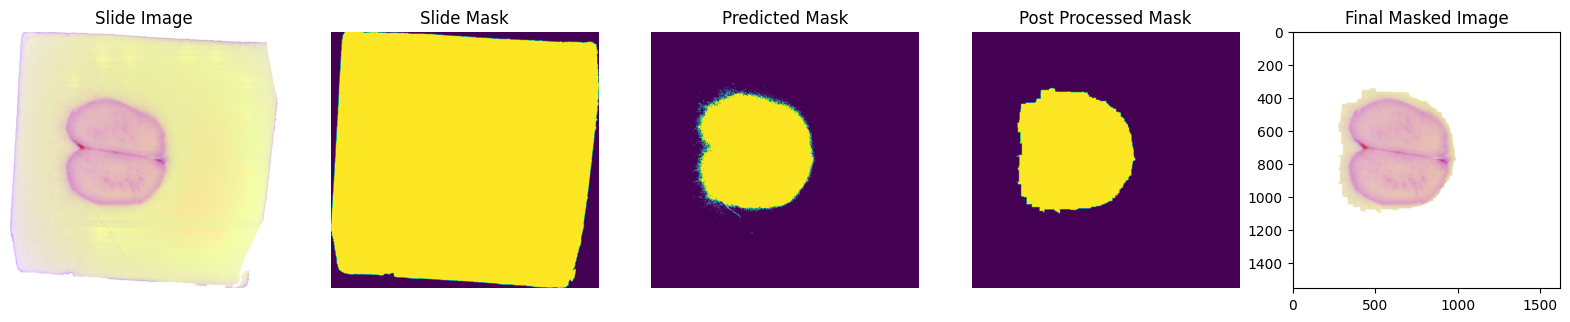

In [167]:
fig, ax = plt.subplots(1, 5, figsize=(20, 10))
ax[0].imshow(slide_img)
ax[0].set_title("Slide Image")
ax[0].axis('off')
ax[1].imshow(slide_mask)
ax[1].set_title("Slide Mask")
ax[1].axis('off')
ax[2].imshow(new_mask.get())
ax[2].set_title("Predicted Mask")
ax[2].axis('off')
ax[3].imshow(final_mask)
ax[3].set_title("Post Processed Mask")
ax[3].axis('off')
cropped_img = cv2.bitwise_and(slide.msr_img, slide.msr_img, mask=final_mask)
cropped_img[final_mask==0] = [255, 255, 255]
ax[4].imshow(cropped_img)
ax[4].set_title("Final Masked Image")
plt.show()


In [121]:
fil_model = model.convert_to_fil_model()

In [ ]:
fil_model.

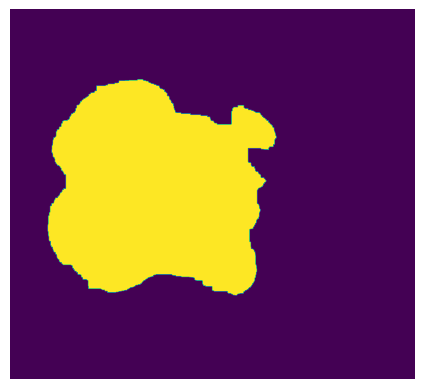

In [119]:
plt.imshow(final_mask)
plt.axis('off')
plt.show()

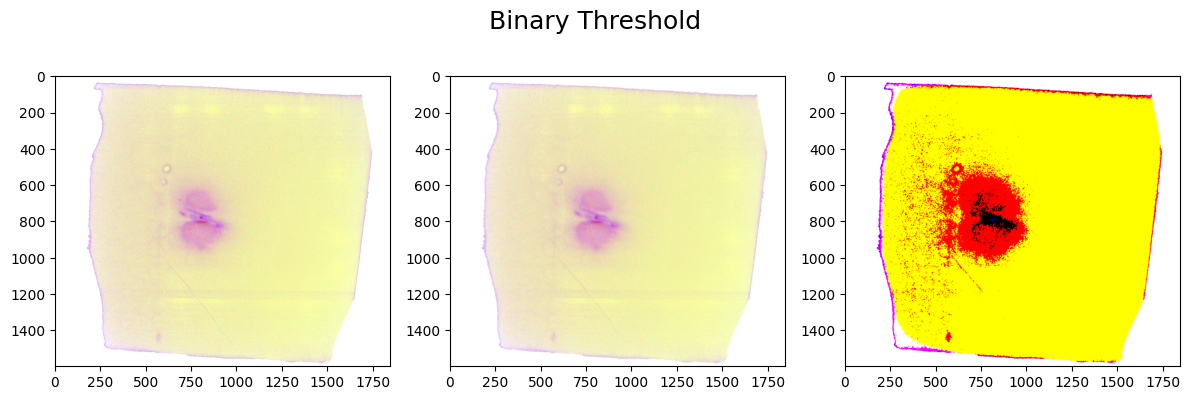

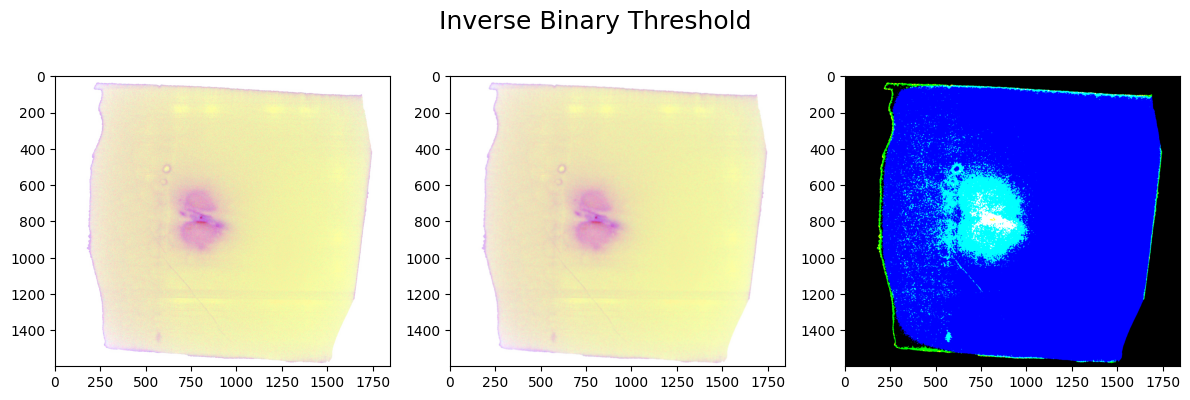

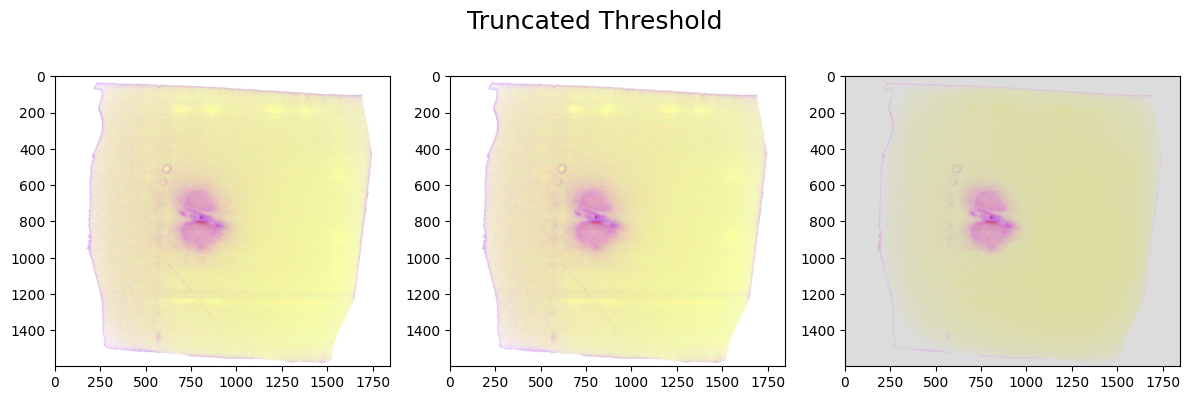

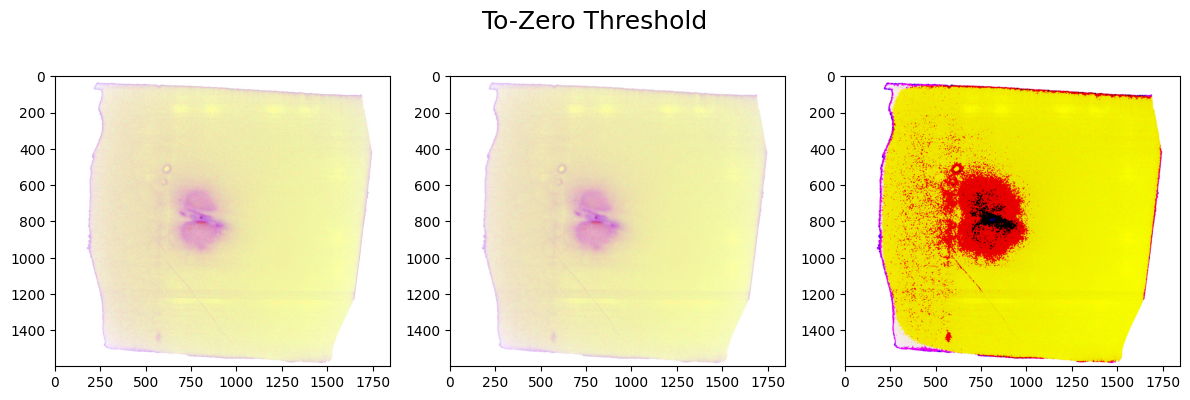

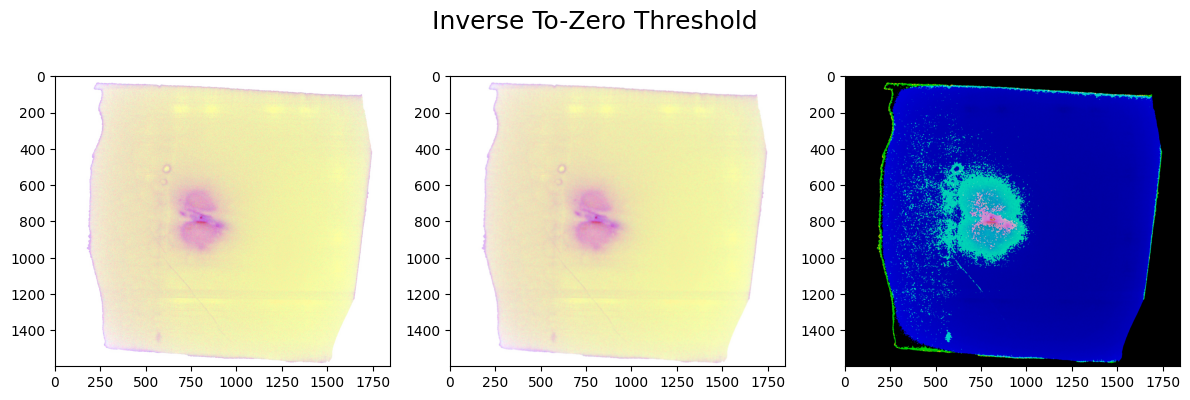

In [118]:
methods = [cv2.THRESH_BINARY, cv2.THRESH_BINARY_INV, cv2.THRESH_TRUNC, cv2.THRESH_TOZERO, cv2.THRESH_TOZERO_INV]
names = ['Binary Threshold', 'Inverse Binary Threshold', 'Truncated Threshold', 'To-Zero Threshold', 'Inverse To-Zero Threshold']

def thresh(img_path, method, index):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    blurred = cv2.GaussianBlur(img, (7, 7), 0)
    ret, img_masked = cv2.threshold(blurred, 220, 255, method)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(names[index], fontsize=18)
    ax[0].imshow(img)
    ax[1].imshow(blurred)
    ax[2].imshow(img_masked)
    plt.tight_layout()

for index, method in enumerate(methods):
    thresh('/storage/valis_reg/test_block_out/msrcr/0008_msrcr.jpg', method, index) 

In [77]:
a  = model.convert_to_fil_model()

In [80]:
dd = a.predict(X_val)